### STEPS

#### FInd the light source/ Segmentation: OTSU Binarization, Adaptive thresholding
#### Patch based threshold segmentation


#### Remove glares
- Find Contours
- Average color in each contours
- Recolor the cntours

#### Find the boundry and center pixel of the light source
#### Gnerate light flares(filter banks based on size of light source).
#### Apply flares and readjust the color using the previously generated contours

#### Apply spherical distortion

In [1]:
import numpy as np
import cv2
import os
from PIL import Image as IMG
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import queue

In [2]:
# cdir = os.getcwd()
# os.chdir('../ature')
# import utils.img_utils as iu
# os.chdir(cdir)

### Approach 1 : Gloab segementation

In [3]:
class LightSrc():
    def __init__(self, center, IJs, diam, contour):
        self.center = center
        self.IJs = IJs
        self.diam = diam
        self.contour = contour
        self.flags = {}
        
### Find all light sources contours
def get_ligt_sources(thr):
    ret, labels = cv2.connectedComponents(thr)
    for l in range(1, ret):
        try:
            I, J = np.where(labels==l)
            c = np.zeros_like(labels, dtype=np.uint8)
            c[I, J] = 255

            image, c, hierarchy = cv2.findContours(c, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            
            # compute the center of the contour
            M = cv2.moments(c[0])
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            #Compute diameter
            c = c[0].squeeze()
            ixy = c[c[:,1].argsort()]
            x1, y1 = ixy[0]
            x2, y2 = ixy[-1]
            dst = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

            yield LightSrc(center=(cX, cY), IJs=(I, J), diam=round(dst,2), contour=c)
        except Exception as e:
            print('Failed:', e, end='\r')

### Increase dynamic brightness

In [14]:
def get_binary(F_queue=None):
    f = list(F_queue.queue)
    f_mean= np.array(f).mean(0)
    blur = cv2.GaussianBlur(imgray,(31,31),0)
    thr = blur.copy()
    t= Params['binarize_thr']
    thr[thr>t] = 255
    thr[thr<=t] = 0
    if F_queue.full():
        F_queue.get() 
    return thr

In [15]:
def increase_brightness(img, value=100):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    h1 = math.floor(v.shape[0]/2)
    h2 = math.ceil(v.shape[0]/2)
    
    m1 = np.linspace(0, value, int(h1))
    m2 = np.linspace(0, value, int(h2))[::-1]
    value_row = np.append(m1, m2)[..., None]
    value_row = value_row.astype(np.uint8)

    lim = 255 - value_row
    v[v > lim] = 255
    c = (v <= lim).astype(np.uint8)
    v += c*value_row
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [18]:
Params = {}
Params['input_video'] = 'vid/CV.mp4'
Params['output_video'] = 'vid/flare_output_boundry1.mp4'
Params['write_fps'] = 30.0
Params['binarize_thr'] = 240
Params['conn_comp_diam_limit'] = (20, 500)
Params['light_src_limit'] = 3
Params['bright_increment'] = 40

cap = cv2.VideoCapture(Params['input_video'])
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(Params['output_video'], fourcc, Params['write_fps'], (width,height))

Frames = queue.Queue(maxsize=1) 
while(cap.isOpened()):
    ret, frame_orig = cap.read()
    if ret==True:
        frame = frame_orig.copy()
        imgray = frame[:,:,1]
        Frames.put(imgray)
        thr = get_binary(Frames)
        
        # Draw contour for all light sources
        added_light_src_count = 0
        for src in get_ligt_sources(thr):
            
            # Option to specify number of flares to generate
            if added_light_src_count >= Params['light_src_limit']:
                break
            
#             # Only pick selected size of light sources
            if src.diam < Params['conn_comp_diam_limit'][0] or src.diam > Params['conn_comp_diam_limit'][1]:
                continue
                
            # Only pick the contours where all RGB values are higher than a threshold
            rgb_max = frame[src.IJs].max(0).astype(float)
            if  (rgb_max >= [Params['binarize_thr']] * 3).sum() < 3:
                continue

#             cv2.drawContours(frame, [src.contour], -1, (0, 255, 0), 2)
#             cv2.circle(frame, src.center, 2, (255, 0, 0), -1)
            
            
            # Find the horigental span of each flare
            sorted_x = src.contour[src.contour[:,1].argsort()]
            u, v = sorted_x[0], sorted_x[-1]
#             frame[u[1], :, 1]=255
#             frame[v[1], :, 1]=255
            
            # Increase brightness with an offset from boundary
            flare_from, flare_to = u[1], v[1]
            frame[flare_from:flare_to, :, :] = increase_brightness(frame[flare_from:flare_to, :, :], Params['bright_increment'])
            added_light_src_count += 1
        
#         break
        out.write(frame)
#         cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

0

### Patch based

In [ ]:
frame_p = frame_orig.copy()
gen = np.zeros_like(frame_p)
chunks = list(iu.get_chunk_indexes(gen[:,:,0].shape, (150, 150), (150, 150)))
for p, q, r, s in chunks:
    patch = frame_p[p:q, r:s, :]
    
    imgray = cv2.cvtColor(patch,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(imgray,(21,21),0)
    
    thr = blur.copy()
    maxx, minn = blur.max(), blur.min()
#     print(maxx, minn)
    if maxx - minn > 150:
        t = maxx - 10
        thr[thr>t] = 255
        thr[thr<=t] = 0
    
        image, contours, hierarchy = cv2.findContours(thr,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        c = cv2.drawContours(patch, contours, -1, (0,255,0), 3)
        gen[p:q, r:s, :] = patch

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(7,7)
chunkid = 0
for i in range(7):
    for j in range(7):
        try:
            a, b, c, d = chunks[chunkid]
            f = frame_orig[a:b, c:d]
            axarr[i,j].imshow(f)
            axarr[i, j].set_yticklabels([])
            axarr[i, j].set_xticklabels([])
            chunkid += 1
        except:
            pass

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(7,7)
chunkid = 0
for i in range(7):
    for j in range(7):
        try:
            a, b, c, d = chunks[chunkid]
            f = frame_p[a:b, c:d]
            axarr[i,j].imshow(f)
            axarr[i, j].set_yticklabels([])
            axarr[i, j].set_xticklabels([])
            chunkid += 1
        except:
            pass

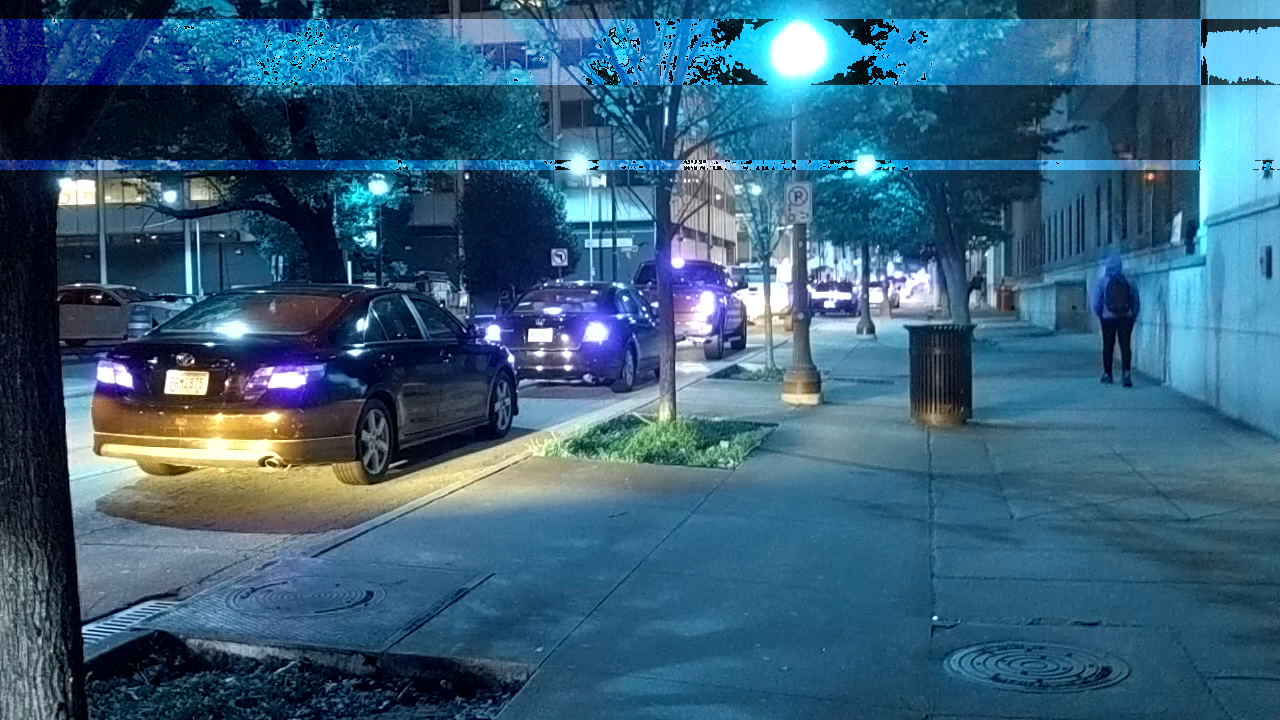

In [136]:
IMG.fromarray(frame)

In [ ]:
len(chunks)

In [ ]:
a = np.array([[1,2], [2,2],[3,1],[3,3]])

In [ ]:
a[-1]

In [ ]:
a[a[:,1].argsort()]

In [ ]:
a

In [ ]:
for i in range(1, 14):
    print(i)

In [ ]:
cap.read.

In [191]:
a = np.array([[4,2],[1,3]])

In [192]:
t = np.array([[2,2]])

In [193]:
a[a>t]+=t

ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (1,2)

In [194]:
import queue

array([[4, 2],
       [1, 3]])

In [20]:
a = [np.array([2,2]), np.array([2,2]), np.array([5,5])]

In [16]:
np.array(a).mean(0)

NameError: name 'a' is not defined

In [23]:
q = queue.Queue(3)

In [24]:
q.put(1)
q.put(2)
q.put(3)

In [27]:
list(q.queue)

[2, 3, 5]

In [13]:
while not q.empty():
    print(q.get())

1
2
3


In [25]:
q.get()

1

In [26]:
q.put(5)

True

In [33]:
a = 10 if q.full() else none

In [34]:
a

10